In [135]:
import imageio as iio
import numpy as np
import pandas as pd
from datetime import timedelta
import dask.dataframe as dd
from PIL import Image, ImageColor

In [8]:
iio.imread("data/2by2sprite.png")

Array([[[255, 255, 255, 255],
        [255,   0,   0, 255]],

       [[  0,   2, 255, 255],
        [ 21, 255,   0, 255]]], dtype=uint8)

In [9]:
frame = np.array([[ImageColor.getrgb("#FFFFFF"), ImageColor.getrgb("#FF0000")], [ImageColor.getrgb("#00FF00"), ImageColor.getrgb("#0000FF")]]).astype("uint8")
# frame = np.array([["#FFFFFF", "#FF0000"], ["#00FF00", "#0000FF"]]).astype("str")
frame = Image.fromarray(frame).resize((10, 10), Image.Resampling.BOX)
# frame = np.vectorize(ImageColor.getrgb)(frame)
frame

In [10]:
frame = np.array(frame)
with iio.get_writer('my_video.mp4', format='FFMPEG', mode='I', fps=1, macro_block_size=2) as w:
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)

In [11]:
canvas = np.full((2000,2000, 3), ImageColor.getrgb("#FFFFFF")).astype("uint8")

frame = canvas
with iio.get_writer('my_video.mp4', format='FFMPEG', mode='I', fps=1) as w:
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)
    w.append_data(frame)

In [147]:
filepath = "data/2022_place_history_sorted.csv"

ddf = dd.read_csv(filepath)

part = ddf.partitions[0]
part.head(1)

,timestamp,user_id,pixel_color,coordinate
0,2022-04-01 12:44:10.315 UTC,lEjremCtNoQaJ6KGBSWsatGEMXwjqoQqGZesWxHdyPetpA...,#7EED56,"42,42"


In [88]:
# for i in range(10, 79):
#     urllib.request.urlretrieve(f"https://placedata.reddit.com/data/canvas-history/2022_place_canvas_history-0000000000{i}.csv.gzip", f"data/{i}.csv.gzip")

In [123]:
# with open("data/2022_place_history_sorted.csv", 'w') as result:
#     for i in range(0, 79):
#         with open(f"data/chunks/{i}.csv") as f:
#             if i > 0:
#                 f.readline();
#             result.write(f.read())

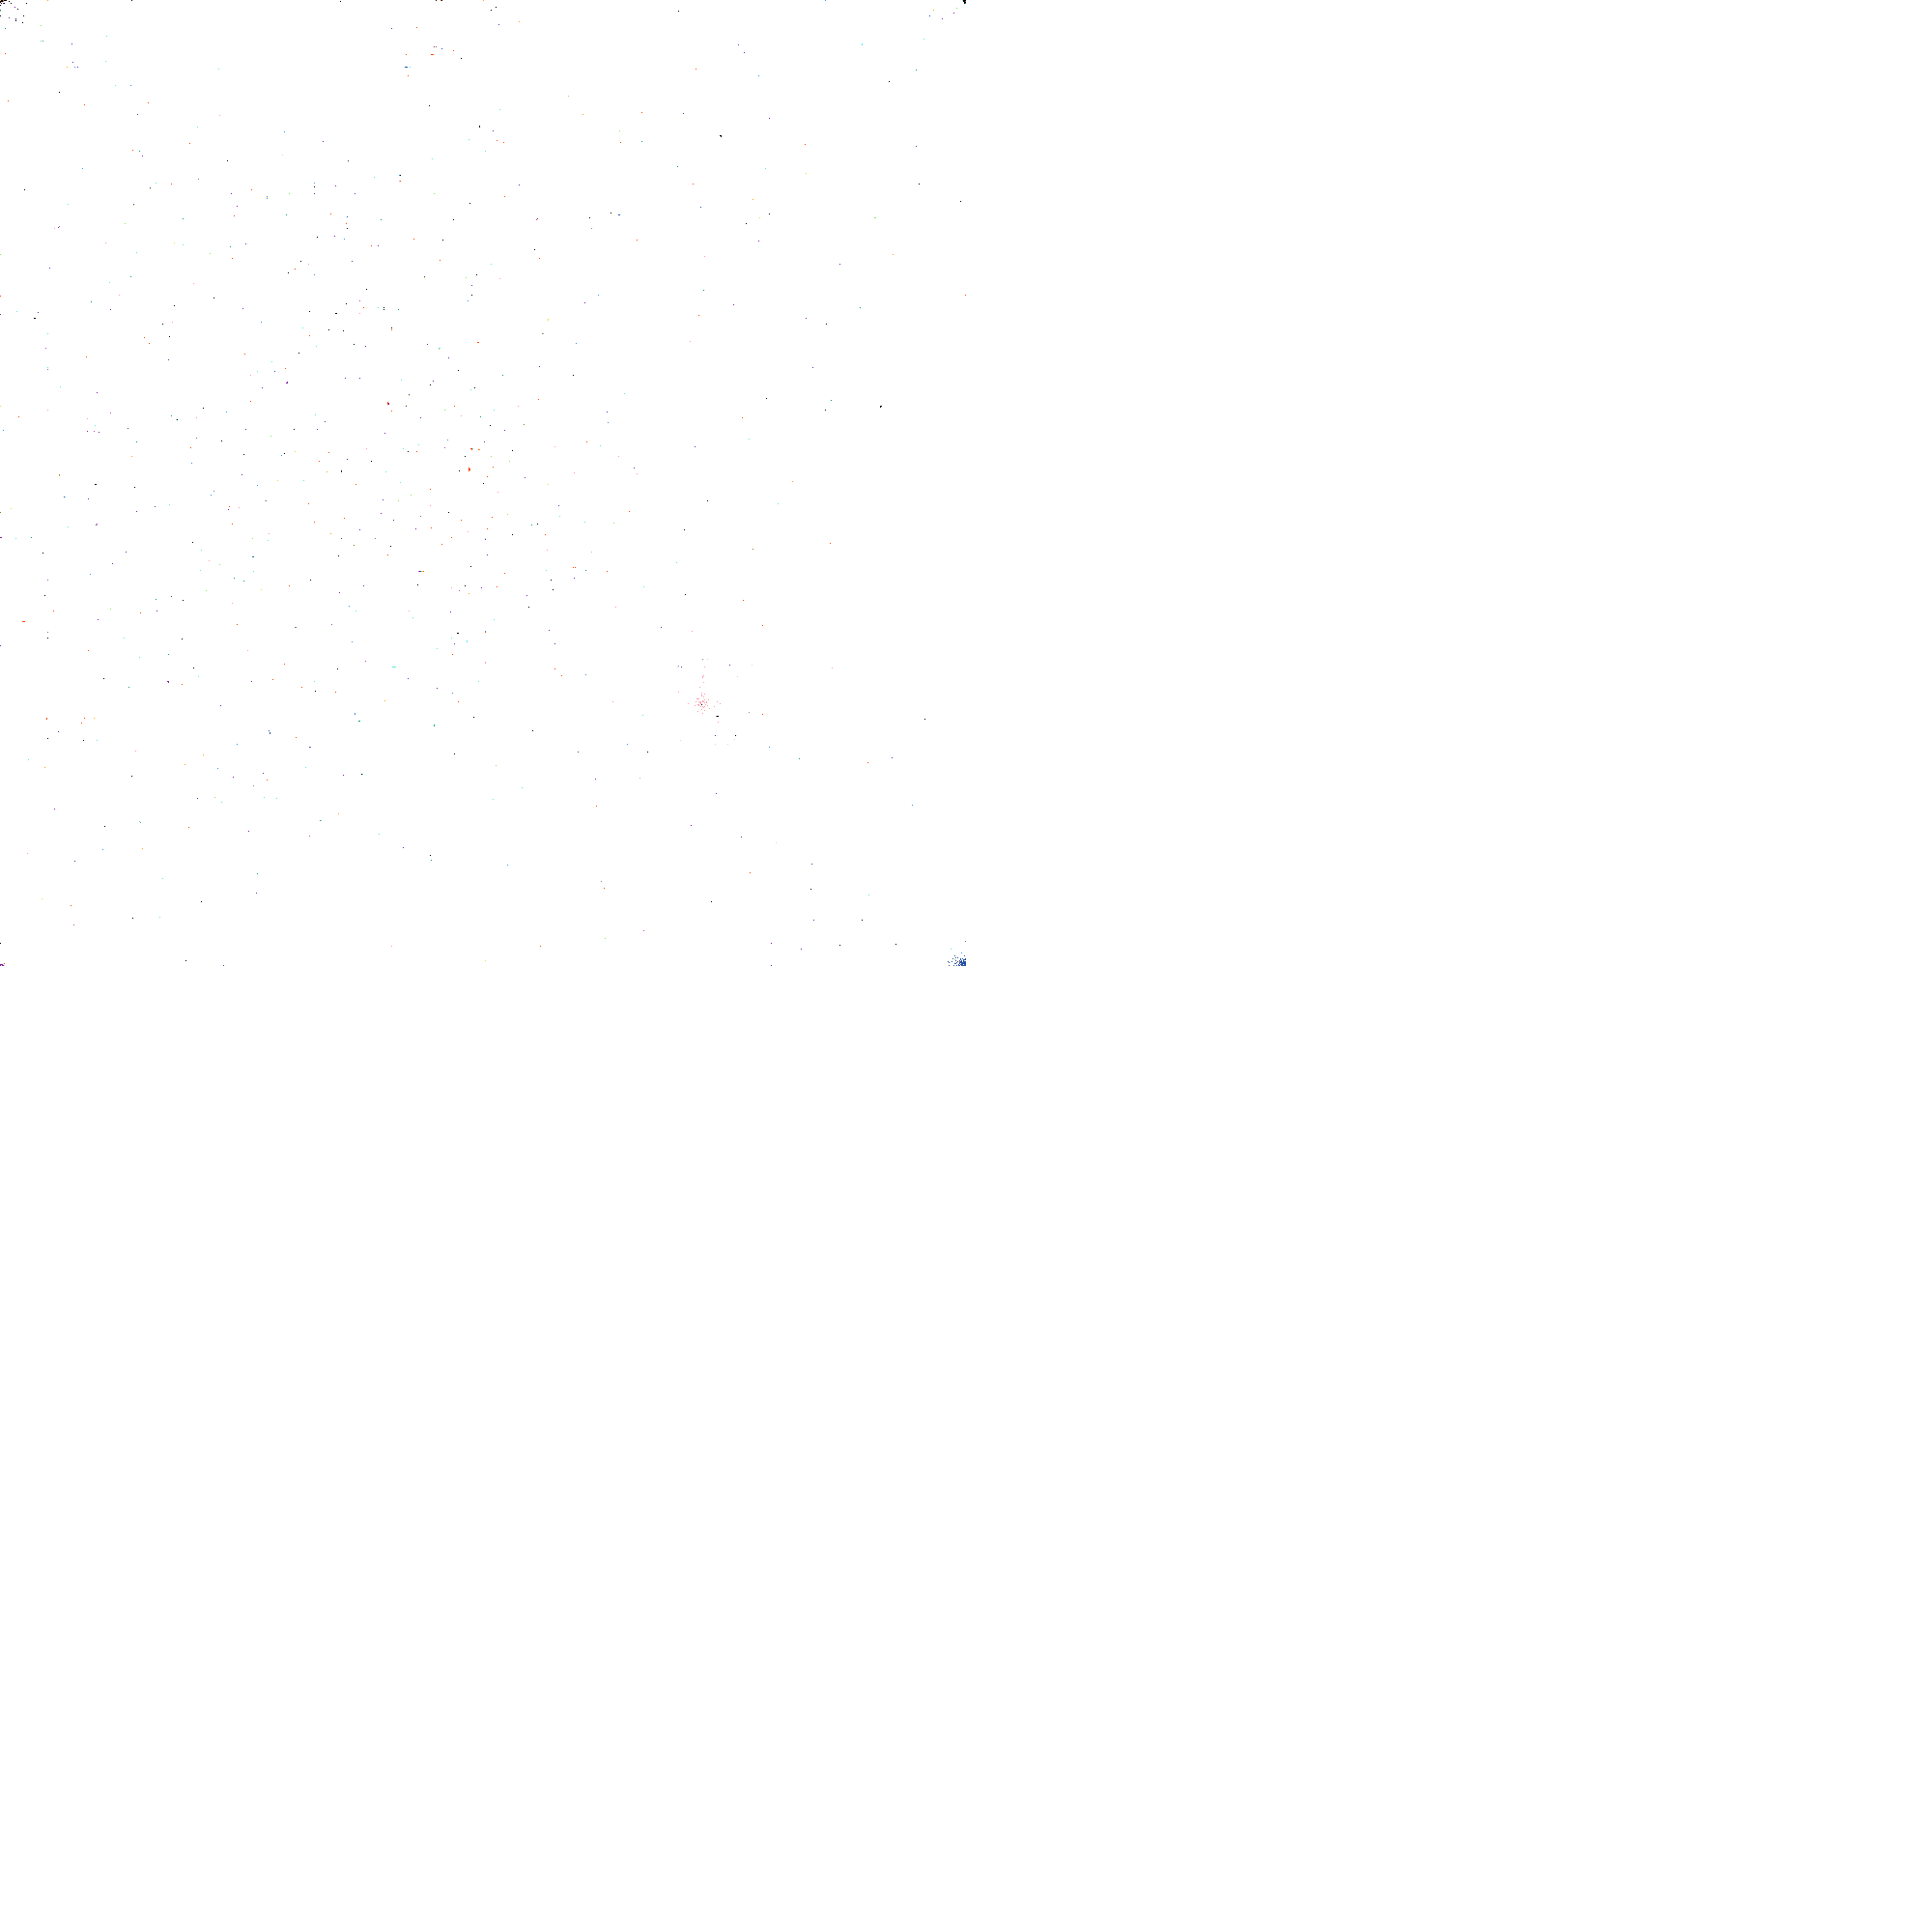

In [142]:
canvas = np.full((2000,2000, 3), ImageColor.getrgb("#FFFFFF")).astype("uint8")

timestamp_idx = 1
user_id_idx = 2
pixel_color_idx = 3
coord_idx = 4

for row in part.head(1000).itertuples():
    coords = row[coord_idx]
    coords_array = coords.split(",")
    y,x = int(coords_array[0]), int(coords_array[1])
    rgb_val = ImageColor.getrgb(row[pixel_color_idx])
    canvas[x][y] = rgb_val

Image.fromarray(canvas)

In [150]:
canvas = np.full((2000,2000, 3), ImageColor.getrgb("#FFFFFF")).astype("uint8")

cur_time = pd.to_datetime(ddf.partitions[0].head(1)["timestamp"][0])
cur_time += timedelta(seconds=1)
count = 0

timestamp_idx = 1
user_id_idx = 2
pixel_color_idx = 3
coord_idx = 4

writer = iio.get_writer('my_video.mp4', format='FFMPEG', mode='I', fps=30)
# for partit in ddf.partitions:
partit = ddf.partitions[0]
partit["timestamp"] = dd.to_datetime(partit["timestamp"])
for row in partit.itertuples():
    coords = row[coord_idx]
    coords_array = coords.split(",")
    y,x = int(coords_array[0]), int(coords_array[1])
    rgb_val = ImageColor.getrgb(row[pixel_color_idx])
    canvas[x][y] = rgb_val
    if row[timestamp_idx] > cur_time:
        # ratchet time forward and write frame
        writer.append_data(canvas)
        cur_time += timedelta(seconds=1)

writer.close()